# **Cell 1**: 套件導入與 Tokenizer 載入 (共 3 個 code cells)

In [22]:
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, GPT2Tokenizer, GPT2Model
from datasets import load_dataset
from evaluate import load
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"
#  You can install and import any other libraries if needed

In [23]:
# Some Chinese punctuations will be tokenized as [UNK], so we replace them with English ones
# 全形符號換半形符號，否則模型無法辨識(不在辭庫)
token_replacement = [
    ["：" , ":"],
    ["，" , ","],
    ["“" , "\""],
    ["”" , "\""],
    ["？" , "?"],
    ["……" , "..."],
    ["！" , "!"]
]

In [24]:
# Load tokenizers for different models
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base", cache_dir="./cache/")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", cache_dir="./cache/")
# GPT2 doesn't have a padding token by default, so we set it
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# **Cell 5**: 資料集定義與載入 (共 2 個 code cells)

In [25]:
# Input: Two sentences ("premise", "hypothesis") 
# Output: 1. Similarity score 2. Entailment relation
import csv
from torch.utils.data import Dataset

class SemevalDataset(Dataset):
    def __init__(self, split="train") -> None:
        super().__init__()
        print(f"Loading SICK dataset ({split} split)...")
        
        # Read SICK.txt file
        sick_file = "./SICK.txt"
        self.data = []
        
        # Map split names to SICK dataset splits
        split_map = {
            "train": "TRAIN",
            "validation": "TRIAL",  # Use TRIAL as validation
            "test": "TEST"
        }
        target_split = split_map.get(split, "TRAIN")
        
        # Read TSV file
        with open(sick_file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for row in reader:
                # Filter by split
                if row['SemEval_set'] == target_split:
                    # Get entailment label
                    entailment_str = row['entailment_label']
                    
                    self.data.append({
                        "sentence_A": row['sentence_A'],
                        "sentence_B": row['sentence_B'],
                        "relatedness_score": float(row['relatedness_score']),
                        "entailment_judgment": entailment_str
                    })
        
        print(f"Loaded {len(self.data)} samples from SICK {target_split} set")
    
    # Entailment label mapping
    def _map_label(self, label):
        """Map string labels to integers"""
        if isinstance(label, int):
            return label
        label_map = {
            "ENTAILMENT": 0,       # Entailment: B can be inferred from A
            "NEUTRAL": 1,          # Neutral: A and B have no clear logical relationship
            "CONTRADICTION": 2     # Contradiction: A and B conflict with each other
        }
        return label_map.get(label.upper() if isinstance(label, str) else "NEUTRAL", 1)

    def __getitem__(self, index):
        d = self.data[index]
        
        # Extract fields from SICK format
        sentence_A = d.get("sentence_A", "")
        sentence_B = d.get("sentence_B", "")
        
        # Relatedness score (1-5 in SICK)
        relatedness = float(d.get("relatedness_score", 3.0))
        
        # Entailment label
        entailment_raw = d.get("entailment_judgment", "NEUTRAL")
        entailment = self._map_label(entailment_raw)
        
        result = {
            "premise": str(sentence_A),
            "hypothesis": str(sentence_B),
            "relatedness_score": relatedness,
            "entailment_judgment": entailment
        }
        
        # Replace full-width punctuation with half-width, otherwise model cannot recognize (not in vocabulary)
        for k in ["premise", "hypothesis"]:
            for tok in token_replacement:
                result[k] = result[k].replace(tok[0], tok[1])
        return result

    def __len__(self):
        return len(self.data)


# Test loading
dataset_train = SemevalDataset(split="train")
print(f"\nFirst sample:")
sample = dataset_train[0]
print(f"Premise: {sample['premise'][:100]}...")
print(f"Hypothesis: {sample['hypothesis'][:100]}...")
print(f"Relatedness: {sample['relatedness_score']}")
print(f"Entailment: {sample['entailment_judgment']}")

Loading SICK dataset (train split)...
Loaded 4439 samples from SICK TRAIN set

First sample:
Premise: A group of kids is playing in a yard and an old man is standing in the background...
Hypothesis: A group of boys in a yard is playing and a man is standing in the background...
Relatedness: 4.5
Entailment: 1


In [26]:
train_set = SemevalDataset(split='train')
val_set = SemevalDataset(split='validation')
test_set = SemevalDataset(split='test')

print(f"訓練集大小: {len(train_set)}")
print(f"驗證集大小: {len(val_set)}")
print(f"測試集大小: {len(test_set)}")


Loading SICK dataset (train split)...
Loaded 4439 samples from SICK TRAIN set
Loading SICK dataset (validation split)...
Loaded 495 samples from SICK TRIAL set
Loading SICK dataset (test split)...
Loaded 4906 samples from SICK TEST set
訓練集大小: 4439
驗證集大小: 495
測試集大小: 4906


# **Cell 8**: 超參數設定

In [ ]:
# Define the hyperparameters
# You can modify these values if needed
lr = 3e-5
epochs = 10
train_batch_size = 8
validation_batch_size = 8

# **Cell 10**: BERT DataLoader 與 Collate Function

In [28]:
# TODO1: Create batched data for DataLoader
# `collate_fn` is a function that defines how the data batch should be packed.
# This function will be called in the DataLoader to pack the data batch.

def collate_fn(batch):
    # TODO1-1: Implement the collate_fn function
    # Write your code here
    # The input parameter is a data batch (tuple), and this function packs it into tensors.
    # Use tokenizer to pack tokenize and pack the data and its corresponding labels.
    # Return the data batch and labels for each sub-task.
    
    # Write your code here
    premises = [item["premise"] for item in batch]
    hypotheses = [item["hypothesis"] for item in batch]
    relatedness_scores = torch.tensor([item["relatedness_score"] for item in batch], dtype=torch.float)
    entailment_labels = torch.tensor([item["entailment_judgment"] for item in batch], dtype=torch.long)
    
    # Tokenize the premise and hypothesis pairs
    encodings = tokenizer(
        premises, 
        hypotheses, 
        padding=True, 
        truncation=True, 
        max_length=128, 
        return_tensors="pt"
    )
    
    return encodings, relatedness_scores, entailment_labels

# TODO1-2: Define your DataLoader
dl_train = DataLoader(SemevalDataset(split="train"), batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn) # Write your code here
dl_validation = DataLoader(SemevalDataset(split="validation"), batch_size=validation_batch_size, shuffle=False, collate_fn=collate_fn) # Write your code here
dl_test = DataLoader(SemevalDataset(split="test"), batch_size=validation_batch_size, shuffle=False, collate_fn=collate_fn) # Write your code here

Loading SICK dataset (train split)...
Loaded 4439 samples from SICK TRAIN set
Loading SICK dataset (validation split)...
Loaded 495 samples from SICK TRIAL set
Loading SICK dataset (test split)...
Loaded 4906 samples from SICK TEST set


# **Cell 12**: RoBERTa 與 GPT-2 DataLoader

In [29]:
# Collate functions for different tokenizers
def collate_fn_roberta(batch):
    premises = [item["premise"] for item in batch]
    hypotheses = [item["hypothesis"] for item in batch]
    relatedness_scores = torch.tensor([item["relatedness_score"] for item in batch], dtype=torch.float)
    entailment_labels = torch.tensor([item["entailment_judgment"] for item in batch], dtype=torch.long)
    
    encodings = roberta_tokenizer(
        premises, 
        hypotheses, 
        padding=True, 
        truncation=True, 
        max_length=128, 
        return_tensors="pt"
    )
    
    return encodings, relatedness_scores, entailment_labels

def collate_fn_gpt2(batch):
    premises = [item["premise"] for item in batch]
    hypotheses = [item["hypothesis"] for item in batch]
    relatedness_scores = torch.tensor([item["relatedness_score"] for item in batch], dtype=torch.float)
    entailment_labels = torch.tensor([item["entailment_judgment"] for item in batch], dtype=torch.long)
    
    # For GPT2, we concatenate premise and hypothesis with a separator
    texts = [f"{p} {gpt2_tokenizer.eos_token} {h}" for p, h in zip(premises, hypotheses)]
    encodings = gpt2_tokenizer(
        texts,
        padding=True, 
        truncation=True, 
        max_length=128, 
        return_tensors="pt"
    )
    
    return encodings, relatedness_scores, entailment_labels

# DataLoaders for RoBERTa
dl_train_roberta = DataLoader(SemevalDataset(split="train"), batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn_roberta)
dl_validation_roberta = DataLoader(SemevalDataset(split="validation"), batch_size=validation_batch_size, shuffle=False, collate_fn=collate_fn_roberta)
dl_test_roberta = DataLoader(SemevalDataset(split="test"), batch_size=validation_batch_size, shuffle=False, collate_fn=collate_fn_roberta)

# DataLoaders for GPT2
dl_train_gpt2 = DataLoader(SemevalDataset(split="train"), batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn_gpt2)
dl_validation_gpt2 = DataLoader(SemevalDataset(split="validation"), batch_size=validation_batch_size, shuffle=False, collate_fn=collate_fn_gpt2)
dl_test_gpt2 = DataLoader(SemevalDataset(split="test"), batch_size=validation_batch_size, shuffle=False, collate_fn=collate_fn_gpt2)

Loading SICK dataset (train split)...
Loaded 4439 samples from SICK TRAIN set
Loading SICK dataset (validation split)...
Loaded 495 samples from SICK TRIAL set
Loading SICK dataset (test split)...
Loaded 4906 samples from SICK TEST set
Loading SICK dataset (train split)...
Loaded 4439 samples from SICK TRAIN set
Loading SICK dataset (validation split)...
Loaded 495 samples from SICK TRIAL set
Loading SICK dataset (test split)...
Loaded 4906 samples from SICK TEST set
Loaded 495 samples from SICK TRIAL set
Loading SICK dataset (test split)...
Loaded 4906 samples from SICK TEST set
Loading SICK dataset (train split)...
Loaded 4439 samples from SICK TRAIN set
Loading SICK dataset (validation split)...
Loaded 495 samples from SICK TRIAL set
Loading SICK dataset (test split)...
Loaded 4906 samples from SICK TEST set


# **Cell 14**: BERT 多任務模型定義

In [30]:
# TODO2: Construct your model
class MultiLabelModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Write your code here
        # Define what modules you will use in the model
        # Please use "google-bert/bert-base-uncased" model (https://huggingface.co/google-bert/bert-base-uncased)
        # Besides the base model, you may design additional architectures by incorporating linear layers, activation functions, or other neural components.
        # Remark: The use of any additional pretrained language models is not permitted.
        
        # Write your code here
        self.bert = BertModel.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")
        hidden_size = self.bert.config.hidden_size  # 768 for bert-base
        
        # Regression head for relatedness score prediction
        self.relatedness_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 1)  # Output a single score
        )
        
        # Classification head for entailment judgment (3 classes: ENTAILMENT, CONTRADICTION, NEUTRAL)
        self.entailment_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 3)  # Output 3 classes
        )
        
    def forward(self, **kwargs):
        # Write your code here
        # Forward pass
        
        # Write your code here
        # Get BERT outputs
        outputs = self.bert(**kwargs)
        # Use [CLS] token representation for classification
        cls_output = outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)
        
        # Get predictions for both tasks
        relatedness_score = self.relatedness_head(cls_output).squeeze(-1)  # Shape: (batch_size,)
        entailment_logits = self.entailment_head(cls_output)  # Shape: (batch_size, 3)
        
        return relatedness_score, entailment_logits

# **Cell 16**: RoBERTa、GPT-2 與單任務 BERT 模型定義

In [31]:
# RoBERTa Multi-output Model
class MultiLabelModelRoBERTa(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.roberta = RobertaModel.from_pretrained("roberta-base", cache_dir="./cache/")
        hidden_size = self.roberta.config.hidden_size  # 768 for roberta-base
        
        # Regression head for relatedness score prediction
        self.relatedness_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 1)
        )
        
        # Classification head for entailment judgment
        self.entailment_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 3)
        )
        
    def forward(self, **kwargs):
        outputs = self.roberta(**kwargs)
        cls_output = outputs.last_hidden_state[:, 0, :]
        
        relatedness_score = self.relatedness_head(cls_output).squeeze(-1)
        entailment_logits = self.entailment_head(cls_output)
        
        return relatedness_score, entailment_logits

# GPT-2 Multi-output Model
class MultiLabelModelGPT2(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gpt2 = GPT2Model.from_pretrained("gpt2", cache_dir="./cache/")
        hidden_size = self.gpt2.config.hidden_size  # 768 for gpt2
        
        # Regression head for relatedness score prediction
        self.relatedness_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 1)
        )
        
        # Classification head for entailment judgment
        self.entailment_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 3)
        )
        
    def forward(self, **kwargs):
        outputs = self.gpt2(**kwargs)
        # GPT2 doesn't have a [CLS] token, so we use the last token's representation
        last_token_output = outputs.last_hidden_state[:, -1, :]
        
        relatedness_score = self.relatedness_head(last_token_output).squeeze(-1)
        entailment_logits = self.entailment_head(last_token_output)
        
        return relatedness_score, entailment_logits

# Single-task BERT Models (for comparison with multi-output learning)
class SingleTaskRelatednessModel(torch.nn.Module):
    """BERT model for relatedness score prediction only"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.bert = BertModel.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")
        hidden_size = self.bert.config.hidden_size
        
        self.relatedness_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 1)
        )
        
    def forward(self, **kwargs):
        outputs = self.bert(**kwargs)
        cls_output = outputs.last_hidden_state[:, 0, :]
        relatedness_score = self.relatedness_head(cls_output).squeeze(-1)
        return relatedness_score

class SingleTaskEntailmentModel(torch.nn.Module):
    """BERT model for entailment classification only"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.bert = BertModel.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")
        hidden_size = self.bert.config.hidden_size
        
        self.entailment_head = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 3)
        )
        
    def forward(self, **kwargs):
        outputs = self.bert(**kwargs)
        cls_output = outputs.last_hidden_state[:, 0, :]
        entailment_logits = self.entailment_head(cls_output)
        return entailment_logits

# **Cell 18**: 優化器與損失函數定義

In [32]:
# TODO3: Define your optimizer and loss function

model = MultiLabelModel().to(device)
# TODO3-1: Define your Optimizer
optimizer = AdamW(model.parameters(), lr=lr) # Write your code here

# TODO3-2: Define your loss functions (you should have two)
# Write your code here
# Loss function for regression task (relatedness score)
relatedness_loss_fn = torch.nn.MSELoss()
# Loss function for classification task (entailment judgment)
entailment_loss_fn = torch.nn.CrossEntropyLoss()

# **Cell 20**: BERT 模型訓練與驗證 (共 2 個 code cells)

In [33]:
# Create directory for saving models
import os
os.makedirs('./saved_models', exist_ok=True)

print("=" * 60)
print("Training BERT-base Multi-output Model")
print("=" * 60)

Training BERT-base Multi-output Model


In [34]:
best_score = 0.0
for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"[BERT] Training epoch [{ep+1}/{epochs}]")
    model.train()
    # TODO4: Write the training loop
    # Write your code here
    # train your model
    # clear gradient
    # forward pass
    # compute loss
    # back-propagation
    # model optimization
    
    # Write your code here
    for batch in pbar:
        encodings, relatedness_scores, entailment_labels = batch
        encodings = {k: v.to(device) for k, v in encodings.items()}
        relatedness_scores = relatedness_scores.to(device)
        entailment_labels = entailment_labels.to(device)
        
        # Clear gradient
        optimizer.zero_grad()
        
        # Forward pass
        pred_relatedness, pred_entailment = model(**encodings)
        
        # Compute loss for both tasks
        loss_relatedness = relatedness_loss_fn(pred_relatedness, relatedness_scores)
        loss_entailment = entailment_loss_fn(pred_entailment, entailment_labels)
        # Combine losses (you can adjust weights if needed)
        loss = loss_relatedness + loss_entailment
        
        # Back-propagation
        loss.backward()
        
        # Model optimization
        optimizer.step()
        
        pbar.set_postfix({"loss": loss.item()})

    pbar = tqdm(dl_validation)
    pbar.set_description(f"[BERT] Validation epoch [{ep+1}/{epochs}]")
    model.eval()
    # TODO5: Write the evaluation loop
    # Write your code here
    # Evaluate your model
    # Output all the evaluation scores (PearsonCorr, Accuracy)
    
    # Write your code here
    all_pred_relatedness = []
    all_true_relatedness = []
    all_pred_entailment = []
    all_true_entailment = []
    
    with torch.no_grad():
        for batch in pbar:
            encodings, relatedness_scores, entailment_labels = batch
            encodings = {k: v.to(device) for k, v in encodings.items()}
            
            # Forward pass
            pred_relatedness, pred_entailment = model(**encodings)
            
            # Collect predictions
            all_pred_relatedness.extend(pred_relatedness.cpu().numpy().tolist())
            all_true_relatedness.extend(relatedness_scores.numpy().tolist())
            all_pred_entailment.extend(pred_entailment.argmax(dim=-1).cpu().numpy().tolist())
            all_true_entailment.extend(entailment_labels.numpy().tolist())
    
    # Reload metrics for each epoch to avoid accumulation
    psr = load("pearsonr")
    acc = load("accuracy")
    
    pearson_corr = psr.compute(predictions=all_pred_relatedness, references=all_true_relatedness)["pearsonr"] # Write your code here
    accuracy = acc.compute(predictions=all_pred_entailment, references=all_true_entailment)["accuracy"] # Write your code here
    # print(f"F1 Score: {f1.compute()}")
    
    print(f"[BERT] Epoch {ep+1}/{epochs} - Pearson Correlation: {pearson_corr:.4f}, Accuracy: {accuracy:.4f}")
    
    if pearson_corr + accuracy > best_score:
        best_score = pearson_corr + accuracy
        torch.save(model.state_dict(), f'./saved_models/best_model.ckpt')
        print(f"[BERT] Best model saved with score: {best_score:.4f}")
    
    print()  # Add blank line between epochs

[BERT] Validation epoch [1/10]: 100%|██████████| 62/62 [00:00<00:00, 159.25it/s]


[BERT] Epoch 1/10 - Pearson Correlation: 0.8616, Accuracy: 0.8505
[BERT] Best model saved with score: 1.7121

[BERT] Best model saved with score: 1.7121



[BERT] Validation epoch [2/10]: 100%|██████████| 62/62 [00:00<00:00, 156.84it/s]



[BERT] Epoch 2/10 - Pearson Correlation: 0.8702, Accuracy: 0.8545
[BERT] Best model saved with score: 1.7247

[BERT] Best model saved with score: 1.7247



[BERT] Validation epoch [3/10]: 100%|██████████| 62/62 [00:00<00:00, 156.00it/s]


[BERT] Epoch 3/10 - Pearson Correlation: 0.8698, Accuracy: 0.8626
[BERT] Best model saved with score: 1.7324

[BERT] Best model saved with score: 1.7324



[BERT] Validation epoch [4/10]: 100%|██████████| 62/62 [00:00<00:00, 149.52it/s]



[BERT] Epoch 4/10 - Pearson Correlation: 0.8716, Accuracy: 0.8343



[BERT] Validation epoch [5/10]: 100%|██████████| 62/62 [00:00<00:00, 148.87it/s]



[BERT] Epoch 5/10 - Pearson Correlation: 0.8889, Accuracy: 0.8747
[BERT] Best model saved with score: 1.7636

[BERT] Best model saved with score: 1.7636



[BERT] Validation epoch [6/10]: 100%|██████████| 62/62 [00:00<00:00, 156.39it/s]


[BERT] Epoch 6/10 - Pearson Correlation: 0.8700, Accuracy: 0.8566



[BERT] Validation epoch [7/10]: 100%|██████████| 62/62 [00:00<00:00, 153.69it/s]


[BERT] Epoch 7/10 - Pearson Correlation: 0.8851, Accuracy: 0.8727



[BERT] Validation epoch [8/10]: 100%|██████████| 62/62 [00:00<00:00, 157.26it/s]



[BERT] Epoch 8/10 - Pearson Correlation: 0.8555, Accuracy: 0.8424



[BERT] Validation epoch [9/10]: 100%|██████████| 62/62 [00:00<00:00, 149.75it/s]



[BERT] Epoch 9/10 - Pearson Correlation: 0.8745, Accuracy: 0.8566



[BERT] Validation epoch [10/10]: 100%|██████████| 62/62 [00:00<00:00, 156.97it/s]



[BERT] Epoch 10/10 - Pearson Correlation: 0.8756, Accuracy: 0.8606



# **Cell 23**: BERT 模型測試

In [35]:
# Load the model
print("\n" + "=" * 60)
print("Testing BERT-base Model on Test Set")
print("✅ 使用 SICK 測試集進行評估")
print("=" * 60)

model = MultiLabelModel().to(device)
model.load_state_dict(torch.load(f"./saved_models/best_model.ckpt", weights_only=True))

# Use test set for evaluation
pbar = tqdm(dl_test, desc="[BERT] Final Evaluation")
model.eval()

# TODO6: Write the test loop
# Write your code here
# We have loaded the best model with the highest evaluation score for you
# Please implement the test loop to evaluate the model on the test dataset
# We will have 10% of the total score for the test accuracy and pearson correlation

# Write your code here
all_pred_relatedness = []
all_true_relatedness = []
all_pred_entailment = []
all_true_entailment = []

with torch.no_grad():
    for batch in pbar:
        encodings, relatedness_scores, entailment_labels = batch
        encodings = {k: v.to(device) for k, v in encodings.items()}
        
        # Forward pass
        pred_relatedness, pred_entailment = model(**encodings)
        
        # Store predictions and ground truth
        all_pred_relatedness.extend(pred_relatedness.cpu().numpy())
        all_true_relatedness.extend(relatedness_scores.numpy())
        all_pred_entailment.extend(pred_entailment.argmax(dim=-1).cpu().numpy())
        all_true_entailment.extend(entailment_labels.numpy())

# Calculate metrics
psr = load("pearsonr")
acc = load("accuracy")

test_pearson_corr = psr.compute(predictions=all_pred_relatedness, references=all_true_relatedness)['pearsonr']
test_accuracy = acc.compute(predictions=all_pred_entailment, references=all_true_entailment)['accuracy']

print(f"\n{'=' * 60}")
print(f"[BERT Multi-task] Test Set Performance:")
print(f"  Pearson Correlation (Relatedness): {test_pearson_corr:.4f}")
print(f"  Accuracy (Entailment):              {test_accuracy:.4f}")
print(f"  Combined Score:                     {test_pearson_corr + test_accuracy:.4f}")
print(f"{'=' * 60}\n")



Testing BERT-base Model on Test Set
✅ 使用 SICK 測試集進行評估


[BERT] Final Evaluation: 100%|██████████| 614/614 [00:03<00:00, 164.09it/s]



[BERT Multi-task] Test Set Performance:
  Pearson Correlation (Relatedness): 0.8853
  Accuracy (Entailment):              0.8732
  Combined Score:                     1.7585



# **Cell 25**: 問題 1 - RoBERTa 模型訓練與測試 (共 2 個 code cells)

In [36]:
print("=" * 60)
print("Training RoBERTa-base Multi-output Model")
print("=" * 60)

model_roberta = MultiLabelModelRoBERTa().to(device)
optimizer_roberta = AdamW(model_roberta.parameters(), lr=lr)

best_score_roberta = 0.0
for ep in range(epochs):
    pbar = tqdm(dl_train_roberta)
    pbar.set_description(f"[RoBERTa] Training epoch [{ep+1}/{epochs}]")
    model_roberta.train()
    
    for batch in pbar:
        encodings, relatedness_scores, entailment_labels = batch
        encodings = {k: v.to(device) for k, v in encodings.items()}
        relatedness_scores = relatedness_scores.to(device)
        entailment_labels = entailment_labels.to(device)
        
        optimizer_roberta.zero_grad()
        pred_relatedness, pred_entailment = model_roberta(**encodings)
        
        loss_relatedness = relatedness_loss_fn(pred_relatedness, relatedness_scores)
        loss_entailment = entailment_loss_fn(pred_entailment, entailment_labels)
        loss = loss_relatedness + loss_entailment
        
        loss.backward()
        optimizer_roberta.step()
        pbar.set_postfix({"loss": loss.item()})

    pbar = tqdm(dl_validation_roberta)
    pbar.set_description(f"[RoBERTa] Validation epoch [{ep+1}/{epochs}]")
    model_roberta.eval()
    
    all_pred_relatedness = []
    all_true_relatedness = []
    all_pred_entailment = []
    all_true_entailment = []
    
    with torch.no_grad():
        for batch in pbar:
            encodings, relatedness_scores, entailment_labels = batch
            encodings = {k: v.to(device) for k, v in encodings.items()}
            
            pred_relatedness, pred_entailment = model_roberta(**encodings)
            
            all_pred_relatedness.extend(pred_relatedness.cpu().numpy().tolist())
            all_true_relatedness.extend(relatedness_scores.numpy().tolist())
            all_pred_entailment.extend(pred_entailment.argmax(dim=-1).cpu().numpy().tolist())
            all_true_entailment.extend(entailment_labels.numpy().tolist())
    
    # Reload metrics for each epoch to avoid accumulation
    psr_roberta = load("pearsonr")
    acc_roberta = load("accuracy")
    
    pearson_corr = psr_roberta.compute(predictions=all_pred_relatedness, references=all_true_relatedness)["pearsonr"]
    accuracy = acc_roberta.compute(predictions=all_pred_entailment, references=all_true_entailment)["accuracy"]
    
    print(f"[RoBERTa] Epoch {ep+1}/{epochs} - Pearson Correlation: {pearson_corr:.4f}, Accuracy: {accuracy:.4f}")
    
    if pearson_corr + accuracy > best_score_roberta:
        best_score_roberta = pearson_corr + accuracy
        torch.save(model_roberta.state_dict(), f'./saved_models/best_model_roberta.ckpt')
        print(f"[RoBERTa] Best model saved with score: {best_score_roberta:.4f}")
    
    print()  # Add blank line between epochs

Training RoBERTa-base Multi-output Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[RoBERTa] Validation epoch [1/10]: 100%|██████████| 62/62 [00:00<00:00, 184.84it/s]



[RoBERTa] Epoch 1/10 - Pearson Correlation: 0.8670, Accuracy: 0.8525
[RoBERTa] Best model saved with score: 1.7195

[RoBERTa] Best model saved with score: 1.7195



[RoBERTa] Validation epoch [2/10]: 100%|██████████| 62/62 [00:00<00:00, 173.82it/s]



[RoBERTa] Epoch 2/10 - Pearson Correlation: 0.8666, Accuracy: 0.8768
[RoBERTa] Best model saved with score: 1.7434

[RoBERTa] Best model saved with score: 1.7434



[RoBERTa] Validation epoch [3/10]: 100%|██████████| 62/62 [00:00<00:00, 177.33it/s]



[RoBERTa] Epoch 3/10 - Pearson Correlation: 0.8806, Accuracy: 0.8707
[RoBERTa] Best model saved with score: 1.7513

[RoBERTa] Best model saved with score: 1.7513



[RoBERTa] Validation epoch [4/10]: 100%|██████████| 62/62 [00:00<00:00, 167.99it/s]



[RoBERTa] Epoch 4/10 - Pearson Correlation: 0.8883, Accuracy: 0.8727
[RoBERTa] Best model saved with score: 1.7610

[RoBERTa] Best model saved with score: 1.7610



[RoBERTa] Validation epoch [5/10]: 100%|██████████| 62/62 [00:00<00:00, 175.22it/s]



[RoBERTa] Epoch 5/10 - Pearson Correlation: 0.8844, Accuracy: 0.8424



[RoBERTa] Validation epoch [6/10]: 100%|██████████| 62/62 [00:00<00:00, 174.06it/s]



[RoBERTa] Epoch 6/10 - Pearson Correlation: 0.8856, Accuracy: 0.8545



[RoBERTa] Validation epoch [7/10]: 100%|██████████| 62/62 [00:00<00:00, 169.30it/s]



[RoBERTa] Epoch 7/10 - Pearson Correlation: 0.8873, Accuracy: 0.8626



[RoBERTa] Validation epoch [8/10]: 100%|██████████| 62/62 [00:00<00:00, 175.15it/s]



[RoBERTa] Epoch 8/10 - Pearson Correlation: 0.8934, Accuracy: 0.8667



[RoBERTa] Validation epoch [9/10]: 100%|██████████| 62/62 [00:00<00:00, 175.27it/s]


[RoBERTa] Epoch 9/10 - Pearson Correlation: 0.8806, Accuracy: 0.8808
[RoBERTa] Best model saved with score: 1.7614

[RoBERTa] Best model saved with score: 1.7614



[RoBERTa] Validation epoch [10/10]: 100%|██████████| 62/62 [00:00<00:00, 177.35it/s]



[RoBERTa] Epoch 10/10 - Pearson Correlation: 0.8939, Accuracy: 0.8727
[RoBERTa] Best model saved with score: 1.7667

[RoBERTa] Best model saved with score: 1.7667



In [37]:
# Test RoBERTa Model
print("\n" + "=" * 60)
print("Testing RoBERTa-base Model on Test Set")
print("✅ 使用 SICK 測試集進行評估")
print("=" * 60)

model_roberta = MultiLabelModelRoBERTa().to(device)
model_roberta.load_state_dict(torch.load(f"./saved_models/best_model_roberta.ckpt", weights_only=True))

pbar = tqdm(dl_test_roberta, desc="[RoBERTa] Final Evaluation")
model_roberta.eval()

all_pred_relatedness = []
all_true_relatedness = []
all_pred_entailment = []
all_true_entailment = []

with torch.no_grad():
    for batch in pbar:
        encodings, relatedness_scores, entailment_labels = batch
        encodings = {k: v.to(device) for k, v in encodings.items()}
        
        pred_relatedness, pred_entailment = model_roberta(**encodings)
        
        all_pred_relatedness.extend(pred_relatedness.cpu().numpy().tolist())
        all_true_relatedness.extend(relatedness_scores.numpy().tolist())
        all_pred_entailment.extend(pred_entailment.argmax(dim=-1).cpu().numpy().tolist())
        all_true_entailment.extend(entailment_labels.numpy().tolist())

# Reload metrics to avoid accumulation
psr_roberta_test = load("pearsonr")
acc_roberta_test = load("accuracy")

roberta_test_pearson = psr_roberta_test.compute(predictions=all_pred_relatedness, references=all_true_relatedness)["pearsonr"]
roberta_test_accuracy = acc_roberta_test.compute(predictions=all_pred_entailment, references=all_true_entailment)["accuracy"]

print(f"\n{'='*60}")
print(f"[RoBERTa] Test Set Performance:")
print(f"  Pearson Correlation: {roberta_test_pearson:.4f}")
print(f"  Accuracy: {roberta_test_accuracy:.4f}")
print(f"  Combined Score: {roberta_test_pearson + roberta_test_accuracy:.4f}")
print(f"{'='*60}")



Testing RoBERTa-base Model on Test Set
✅ 使用 SICK 測試集進行評估


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[RoBERTa] Final Evaluation: 100%|██████████| 614/614 [00:03<00:00, 188.83it/s]




[RoBERTa] Test Set Performance:
  Pearson Correlation: 0.8909
  Accuracy: 0.8728
  Combined Score: 1.7637


# **Cell 28**: 問題 2 - GPT-2 模型訓練與測試 (共 2 個 code cells)

In [38]:
print("=" * 60)
print("Training GPT-2 Multi-output Model")
print("=" * 60)

model_gpt2 = MultiLabelModelGPT2().to(device)
optimizer_gpt2 = AdamW(model_gpt2.parameters(), lr=lr)

best_score_gpt2 = 0.0
for ep in range(epochs):
    pbar = tqdm(dl_train_gpt2)
    pbar.set_description(f"[GPT-2] Training epoch [{ep+1}/{epochs}]")
    model_gpt2.train()
    
    for batch in pbar:
        encodings, relatedness_scores, entailment_labels = batch
        encodings = {k: v.to(device) for k, v in encodings.items()}
        relatedness_scores = relatedness_scores.to(device)
        entailment_labels = entailment_labels.to(device)
        
        optimizer_gpt2.zero_grad()
        pred_relatedness, pred_entailment = model_gpt2(**encodings)
        
        loss_relatedness = relatedness_loss_fn(pred_relatedness, relatedness_scores)
        loss_entailment = entailment_loss_fn(pred_entailment, entailment_labels)
        loss = loss_relatedness + loss_entailment
        
        loss.backward()
        optimizer_gpt2.step()
        pbar.set_postfix({"loss": loss.item()})

    pbar = tqdm(dl_validation_gpt2)
    pbar.set_description(f"[GPT-2] Validation epoch [{ep+1}/{epochs}]")
    model_gpt2.eval()
    
    all_pred_relatedness = []
    all_true_relatedness = []
    all_pred_entailment = []
    all_true_entailment = []
    
    with torch.no_grad():
        for batch in pbar:
            encodings, relatedness_scores, entailment_labels = batch
            encodings = {k: v.to(device) for k, v in encodings.items()}
            
            pred_relatedness, pred_entailment = model_gpt2(**encodings)
            
            all_pred_relatedness.extend(pred_relatedness.cpu().numpy().tolist())
            all_true_relatedness.extend(relatedness_scores.numpy().tolist())
            all_pred_entailment.extend(pred_entailment.argmax(dim=-1).cpu().numpy().tolist())
            all_true_entailment.extend(entailment_labels.numpy().tolist())
    
    # Reload metrics for each epoch to avoid accumulation
    psr_gpt2 = load("pearsonr")
    acc_gpt2 = load("accuracy")
    
    pearson_corr = psr_gpt2.compute(predictions=all_pred_relatedness, references=all_true_relatedness)["pearsonr"]
    accuracy = acc_gpt2.compute(predictions=all_pred_entailment, references=all_true_entailment)["accuracy"]
    
    print(f"[GPT-2] Epoch {ep+1}/{epochs} - Pearson Correlation: {pearson_corr:.4f}, Accuracy: {accuracy:.4f}")
    
    if pearson_corr + accuracy > best_score_gpt2:
        best_score_gpt2 = pearson_corr + accuracy
        torch.save(model_gpt2.state_dict(), f'./saved_models/best_model_gpt2.ckpt')
        print(f"[GPT-2] Best model saved with score: {best_score_gpt2:.4f}")
    
    print()  # Add blank line between epochs

Training GPT-2 Multi-output Model


[GPT-2] Validation epoch [1/10]: 100%|██████████| 62/62 [00:00<00:00, 116.04it/s]



[GPT-2] Epoch 1/10 - Pearson Correlation: 0.8230, Accuracy: 0.8303
[GPT-2] Best model saved with score: 1.6533

[GPT-2] Best model saved with score: 1.6533



[GPT-2] Validation epoch [2/10]: 100%|██████████| 62/62 [00:00<00:00, 113.82it/s]



[GPT-2] Epoch 2/10 - Pearson Correlation: 0.8422, Accuracy: 0.8545
[GPT-2] Best model saved with score: 1.6968

[GPT-2] Best model saved with score: 1.6968



[GPT-2] Validation epoch [3/10]: 100%|██████████| 62/62 [00:00<00:00, 114.03it/s]



[GPT-2] Epoch 3/10 - Pearson Correlation: 0.8637, Accuracy: 0.8505
[GPT-2] Best model saved with score: 1.7142

[GPT-2] Best model saved with score: 1.7142



[GPT-2] Validation epoch [4/10]: 100%|██████████| 62/62 [00:00<00:00, 113.53it/s]



[GPT-2] Epoch 4/10 - Pearson Correlation: 0.8548, Accuracy: 0.8606
[GPT-2] Best model saved with score: 1.7154

[GPT-2] Best model saved with score: 1.7154



[GPT-2] Validation epoch [5/10]: 100%|██████████| 62/62 [00:00<00:00, 116.55it/s]



[GPT-2] Epoch 5/10 - Pearson Correlation: 0.8580, Accuracy: 0.8485



[GPT-2] Validation epoch [6/10]: 100%|██████████| 62/62 [00:00<00:00, 113.98it/s]



[GPT-2] Epoch 6/10 - Pearson Correlation: 0.8710, Accuracy: 0.8667
[GPT-2] Best model saved with score: 1.7377

[GPT-2] Best model saved with score: 1.7377



[GPT-2] Validation epoch [7/10]: 100%|██████████| 62/62 [00:00<00:00, 113.60it/s]



[GPT-2] Epoch 7/10 - Pearson Correlation: 0.8663, Accuracy: 0.8646



[GPT-2] Validation epoch [8/10]: 100%|██████████| 62/62 [00:00<00:00, 113.18it/s]



[GPT-2] Epoch 8/10 - Pearson Correlation: 0.8635, Accuracy: 0.8687



[GPT-2] Validation epoch [9/10]: 100%|██████████| 62/62 [00:00<00:00, 113.98it/s]



[GPT-2] Epoch 9/10 - Pearson Correlation: 0.8697, Accuracy: 0.8646



[GPT-2] Validation epoch [10/10]: 100%|██████████| 62/62 [00:00<00:00, 113.51it/s]



[GPT-2] Epoch 10/10 - Pearson Correlation: 0.8590, Accuracy: 0.8727



In [39]:
# Test GPT-2 Model
print("\n" + "=" * 60)
print("Testing GPT-2 Model on Test Set")
print("✅ 使用 SICK 測試集進行評估")
print("=" * 60)

model_gpt2 = MultiLabelModelGPT2().to(device)
model_gpt2.load_state_dict(torch.load(f"./saved_models/best_model_gpt2.ckpt", weights_only=True))

pbar = tqdm(dl_test_gpt2, desc="[GPT-2] Final Evaluation")
model_gpt2.eval()

all_pred_relatedness = []
all_true_relatedness = []
all_pred_entailment = []
all_true_entailment = []

with torch.no_grad():
    for batch in pbar:
        encodings, relatedness_scores, entailment_labels = batch
        encodings = {k: v.to(device) for k, v in encodings.items()}
        
        pred_relatedness, pred_entailment = model_gpt2(**encodings)
        
        all_pred_relatedness.extend(pred_relatedness.cpu().numpy().tolist())
        all_true_relatedness.extend(relatedness_scores.numpy().tolist())
        all_pred_entailment.extend(pred_entailment.argmax(dim=-1).cpu().numpy().tolist())
        all_true_entailment.extend(entailment_labels.numpy().tolist())

# Reload metrics to avoid accumulation
psr_gpt2_test = load("pearsonr")
acc_gpt2_test = load("accuracy")

gpt2_test_pearson = psr_gpt2_test.compute(predictions=all_pred_relatedness, references=all_true_relatedness)["pearsonr"]
gpt2_test_accuracy = acc_gpt2_test.compute(predictions=all_pred_entailment, references=all_true_entailment)["accuracy"]

print(f"\n{'='*60}")
print(f"[GPT-2] Test Set Performance:")
print(f"  Pearson Correlation: {gpt2_test_pearson:.4f}")
print(f"  Accuracy: {gpt2_test_accuracy:.4f}")
print(f"  Combined Score: {gpt2_test_pearson + gpt2_test_accuracy:.4f}")
print(f"{'='*60}")



Testing GPT-2 Model on Test Set
✅ 使用 SICK 測試集進行評估


[GPT-2] Final Evaluation: 100%|██████████| 614/614 [00:05<00:00, 115.31it/s]




[GPT-2] Test Set Performance:
  Pearson Correlation: 0.8703
  Accuracy: 0.8801
  Combined Score: 1.7504


# **Cell 31**: 問題 3 - 單任務 BERT 模型訓練與測試 (共 3 個 code cells)

In [40]:
print("=" * 60)
print("Training Single-task Model: Relatedness Score Prediction")
print("=" * 60)

model_relatedness = SingleTaskRelatednessModel().to(device)
optimizer_relatedness = AdamW(model_relatedness.parameters(), lr=lr)

best_pearson = 0.0
for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"[Single-Relatedness] Training epoch [{ep+1}/{epochs}]")
    model_relatedness.train()
    
    for batch in pbar:
        encodings, relatedness_scores, _ = batch
        encodings = {k: v.to(device) for k, v in encodings.items()}
        relatedness_scores = relatedness_scores.to(device)
        
        optimizer_relatedness.zero_grad()
        pred_relatedness = model_relatedness(**encodings)
        
        loss = relatedness_loss_fn(pred_relatedness, relatedness_scores)
        
        loss.backward()
        optimizer_relatedness.step()
        pbar.set_postfix({"loss": loss.item()})

    pbar = tqdm(dl_validation)
    pbar.set_description(f"[Single-Relatedness] Validation epoch [{ep+1}/{epochs}]")
    model_relatedness.eval()
    
    all_pred_relatedness = []
    all_true_relatedness = []
    
    with torch.no_grad():
        for batch in pbar:
            encodings, relatedness_scores, _ = batch
            encodings = {k: v.to(device) for k, v in encodings.items()}
            
            pred_relatedness = model_relatedness(**encodings)
            
            all_pred_relatedness.extend(pred_relatedness.cpu().numpy().tolist())
            all_true_relatedness.extend(relatedness_scores.numpy().tolist())
    
    # Reload metrics for each epoch to avoid accumulation
    psr_rel = load("pearsonr")
    
    pearson_corr = psr_rel.compute(predictions=all_pred_relatedness, references=all_true_relatedness)["pearsonr"]
    
    print(f"[Single-Relatedness] Epoch {ep+1}/{epochs} - Pearson Correlation: {pearson_corr:.4f}")
    
    if pearson_corr > best_pearson:
        best_pearson = pearson_corr
        torch.save(model_relatedness.state_dict(), f'./saved_models/best_model_relatedness.ckpt')
        print(f"[Single-Relatedness] Best model saved with Pearson: {best_pearson:.4f}")
    
    print()  # Add blank line between epochs

Training Single-task Model: Relatedness Score Prediction


[Single-Relatedness] Validation epoch [1/10]: 100%|██████████| 62/62 [00:00<00:00, 158.43it/s]



[Single-Relatedness] Epoch 1/10 - Pearson Correlation: 0.8665
[Single-Relatedness] Best model saved with Pearson: 0.8665

[Single-Relatedness] Best model saved with Pearson: 0.8665



[Single-Relatedness] Validation epoch [2/10]: 100%|██████████| 62/62 [00:00<00:00, 153.16it/s]


[Single-Relatedness] Epoch 2/10 - Pearson Correlation: 0.8756
[Single-Relatedness] Best model saved with Pearson: 0.8756

[Single-Relatedness] Best model saved with Pearson: 0.8756



[Single-Relatedness] Validation epoch [3/10]: 100%|██████████| 62/62 [00:00<00:00, 160.46it/s]



[Single-Relatedness] Epoch 3/10 - Pearson Correlation: 0.8699



[Single-Relatedness] Validation epoch [4/10]: 100%|██████████| 62/62 [00:00<00:00, 154.45it/s]


[Single-Relatedness] Epoch 4/10 - Pearson Correlation: 0.8810
[Single-Relatedness] Best model saved with Pearson: 0.8810

[Single-Relatedness] Best model saved with Pearson: 0.8810



[Single-Relatedness] Validation epoch [5/10]: 100%|██████████| 62/62 [00:00<00:00, 159.01it/s]



[Single-Relatedness] Epoch 5/10 - Pearson Correlation: 0.8852
[Single-Relatedness] Best model saved with Pearson: 0.8852

[Single-Relatedness] Best model saved with Pearson: 0.8852



[Single-Relatedness] Validation epoch [6/10]: 100%|██████████| 62/62 [00:00<00:00, 152.99it/s]


[Single-Relatedness] Epoch 6/10 - Pearson Correlation: 0.8859
[Single-Relatedness] Best model saved with Pearson: 0.8859

[Single-Relatedness] Best model saved with Pearson: 0.8859



[Single-Relatedness] Validation epoch [7/10]: 100%|██████████| 62/62 [00:00<00:00, 154.98it/s]


[Single-Relatedness] Epoch 7/10 - Pearson Correlation: 0.8829



[Single-Relatedness] Validation epoch [8/10]: 100%|██████████| 62/62 [00:00<00:00, 154.13it/s]


[Single-Relatedness] Epoch 8/10 - Pearson Correlation: 0.8862
[Single-Relatedness] Best model saved with Pearson: 0.8862

[Single-Relatedness] Best model saved with Pearson: 0.8862



[Single-Relatedness] Validation epoch [9/10]: 100%|██████████| 62/62 [00:00<00:00, 148.67it/s]



[Single-Relatedness] Epoch 9/10 - Pearson Correlation: 0.8745



[Single-Relatedness] Validation epoch [10/10]: 100%|██████████| 62/62 [00:00<00:00, 154.21it/s]


[Single-Relatedness] Epoch 10/10 - Pearson Correlation: 0.8817



In [41]:
print("=" * 60)
print("Training Single-task Model: Entailment Classification")
print("=" * 60)

model_entailment = SingleTaskEntailmentModel().to(device)
optimizer_entailment = AdamW(model_entailment.parameters(), lr=lr)

best_accuracy = 0.0
for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"[Single-Entailment] Training epoch [{ep+1}/{epochs}]")
    model_entailment.train()
    
    for batch in pbar:
        encodings, _, entailment_labels = batch
        encodings = {k: v.to(device) for k, v in encodings.items()}
        entailment_labels = entailment_labels.to(device)
        
        optimizer_entailment.zero_grad()
        pred_entailment = model_entailment(**encodings)
        
        loss = entailment_loss_fn(pred_entailment, entailment_labels)
        
        loss.backward()
        optimizer_entailment.step()
        pbar.set_postfix({"loss": loss.item()})

    pbar = tqdm(dl_validation)
    pbar.set_description(f"[Single-Entailment] Validation epoch [{ep+1}/{epochs}]")
    model_entailment.eval()
    
    all_pred_entailment = []
    all_true_entailment = []
    
    with torch.no_grad():
        for batch in pbar:
            encodings, _, entailment_labels = batch
            encodings = {k: v.to(device) for k, v in encodings.items()}
            
            pred_entailment = model_entailment(**encodings)
            
            all_pred_entailment.extend(pred_entailment.argmax(dim=-1).cpu().numpy().tolist())
            all_true_entailment.extend(entailment_labels.numpy().tolist())
    
    # Reload metrics for each epoch to avoid accumulation
    acc_ent = load("accuracy")
    
    accuracy = acc_ent.compute(predictions=all_pred_entailment, references=all_true_entailment)["accuracy"]
    
    print(f"[Single-Entailment] Epoch {ep+1}/{epochs} - Accuracy: {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model_entailment.state_dict(), f'./saved_models/best_model_entailment.ckpt')
        print(f"[Single-Entailment] Best model saved with Accuracy: {best_accuracy:.4f}")
    
    print()  # Add blank line between epochs

Training Single-task Model: Entailment Classification


[Single-Entailment] Validation epoch [1/10]: 100%|██████████| 62/62 [00:00<00:00, 158.61it/s]



[Single-Entailment] Epoch 1/10 - Accuracy: 0.8505
[Single-Entailment] Best model saved with Accuracy: 0.8505

[Single-Entailment] Best model saved with Accuracy: 0.8505



[Single-Entailment] Validation epoch [2/10]: 100%|██████████| 62/62 [00:00<00:00, 153.77it/s]


[Single-Entailment] Epoch 2/10 - Accuracy: 0.8283



[Single-Entailment] Validation epoch [3/10]: 100%|██████████| 62/62 [00:00<00:00, 153.74it/s]


[Single-Entailment] Epoch 3/10 - Accuracy: 0.8424



[Single-Entailment] Validation epoch [4/10]: 100%|██████████| 62/62 [00:00<00:00, 154.44it/s]


[Single-Entailment] Epoch 4/10 - Accuracy: 0.8545
[Single-Entailment] Best model saved with Accuracy: 0.8545

[Single-Entailment] Best model saved with Accuracy: 0.8545



[Single-Entailment] Validation epoch [5/10]: 100%|██████████| 62/62 [00:00<00:00, 153.50it/s]


[Single-Entailment] Epoch 5/10 - Accuracy: 0.8545



[Single-Entailment] Validation epoch [6/10]: 100%|██████████| 62/62 [00:00<00:00, 154.98it/s]


[Single-Entailment] Epoch 6/10 - Accuracy: 0.8505



[Single-Entailment] Validation epoch [7/10]: 100%|██████████| 62/62 [00:00<00:00, 155.58it/s]


[Single-Entailment] Epoch 7/10 - Accuracy: 0.8465



[Single-Entailment] Validation epoch [8/10]: 100%|██████████| 62/62 [00:00<00:00, 154.03it/s]


[Single-Entailment] Epoch 8/10 - Accuracy: 0.8707
[Single-Entailment] Best model saved with Accuracy: 0.8707

[Single-Entailment] Best model saved with Accuracy: 0.8707



[Single-Entailment] Validation epoch [9/10]: 100%|██████████| 62/62 [00:00<00:00, 155.02it/s]


[Single-Entailment] Epoch 9/10 - Accuracy: 0.8566



[Single-Entailment] Validation epoch [10/10]: 100%|██████████| 62/62 [00:00<00:00, 154.82it/s]


[Single-Entailment] Epoch 10/10 - Accuracy: 0.8485



In [42]:
# Test Single-task Models
print("\n" + "=" * 60)
print("Testing Single-task Models on Test Set")
print("✅ 使用 SICK 測試集進行評估")
print("=" * 60)

# Test Relatedness Model
model_relatedness = SingleTaskRelatednessModel().to(device)
model_relatedness.load_state_dict(torch.load(f"./saved_models/best_model_relatedness.ckpt", weights_only=True))
model_relatedness.eval()

all_pred_relatedness = []
all_true_relatedness = []

with torch.no_grad():
    for batch in tqdm(dl_test, desc="[Single-Relatedness] Final Evaluation"):
        encodings, relatedness_scores, _ = batch
        encodings = {k: v.to(device) for k, v in encodings.items()}
        
        pred_relatedness = model_relatedness(**encodings)
        
        all_pred_relatedness.extend(pred_relatedness.cpu().numpy().tolist())
        all_true_relatedness.extend(relatedness_scores.numpy().tolist())

# Reload metrics to avoid accumulation
psr_rel_test = load("pearsonr")
single_relatedness_pearson = psr_rel_test.compute(predictions=all_pred_relatedness, references=all_true_relatedness)["pearsonr"]

# Test Entailment Model
model_entailment = SingleTaskEntailmentModel().to(device)
model_entailment.load_state_dict(torch.load(f"./saved_models/best_model_entailment.ckpt", weights_only=True))
model_entailment.eval()

all_pred_entailment = []
all_true_entailment = []

with torch.no_grad():
    for batch in tqdm(dl_test, desc="[Single-Entailment] Final Evaluation"):
        encodings, _, entailment_labels = batch
        encodings = {k: v.to(device) for k, v in encodings.items()}
        
        pred_entailment = model_entailment(**encodings)
        
        all_pred_entailment.extend(pred_entailment.argmax(dim=-1).cpu().numpy().tolist())
        all_true_entailment.extend(entailment_labels.numpy().tolist())

# Reload metrics to avoid accumulation
acc_ent_test = load("accuracy")
single_entailment_accuracy = acc_ent_test.compute(predictions=all_pred_entailment, references=all_true_entailment)["accuracy"]

print(f"\n{'='*60}")
print(f"[Single-task Models] Test Set Performance:")
print(f"  Relatedness - Pearson Correlation: {single_relatedness_pearson:.4f}")
print(f"  Entailment - Accuracy: {single_entailment_accuracy:.4f}")
print(f"{'='*60}")



Testing Single-task Models on Test Set
✅ 使用 SICK 測試集進行評估


[Single-Relatedness] Final Evaluation: 100%|██████████| 614/614 [00:03<00:00, 166.32it/s]

[Single-Entailment] Final Evaluation: 100%|██████████| 614/614 [00:03<00:00, 166.66it/s]




[Single-task Models] Test Set Performance:
  Relatedness - Pearson Correlation: 0.8907
  Entailment - Accuracy: 0.8663


# **Cell 35**: 實驗結果比較表格

In [43]:
# Create comprehensive comparison table
print("\n" + "=" * 80)
print("                    完整實驗結果比較表                    ")
print("=" * 80)

results_data = {
    "模型": [
        "BERT-base (Multi-output)",
        "RoBERTa-base (Multi-output)",
        "GPT-2 (Multi-output)",
        "BERT-base (Single-task: Relatedness)",
        "BERT-base (Single-task: Entailment)"
    ],
    "Pearson Correlation (相似度)": [
        f"{test_pearson_corr:.4f}",
        f"{roberta_test_pearson:.4f}",
        f"{gpt2_test_pearson:.4f}",
        f"{single_relatedness_pearson:.4f}",
        "N/A"
    ],
    "Accuracy (蘊含關係)": [
        f"{test_accuracy:.4f}",
        f"{roberta_test_accuracy:.4f}",
        f"{gpt2_test_accuracy:.4f}",
        "N/A",
        f"{single_entailment_accuracy:.4f}"
    ],
    "Combined Score": [
        f"{test_pearson_corr + test_accuracy:.4f}",
        f"{roberta_test_pearson + roberta_test_accuracy:.4f}",
        f"{gpt2_test_pearson + gpt2_test_accuracy:.4f}",
        "N/A",
        "N/A"
    ]
}

df_results = pd.DataFrame(results_data)
print("\n", df_results.to_string(index=False))

print("\n" + "=" * 80)
print("                    模型訓練參數設定                    ")
print("=" * 80)
print(f"學習率 (Learning Rate): {lr}")
print(f"訓練週期 (Epochs): {epochs}")
print(f"批次大小 (Batch Size): {train_batch_size}")
print(f"最大序列長度 (Max Length): 128")
print(f"優化器 (Optimizer): AdamW")
print(f"損失函數 (Loss Functions): MSELoss (relatedness) + CrossEntropyLoss (entailment)")
print(f"設備 (Device): {device}")
print("=" * 80)

# Save results to CSV for report
df_results.to_csv('./saved_models/experiment_results.csv', index=False, encoding='utf-8-sig')
print("\n✅ 實驗結果已保存至: ./saved_models/experiment_results.csv")


                    完整實驗結果比較表                    

                                   模型 Pearson Correlation (相似度) Accuracy (蘊含關係) Combined Score
            BERT-base (Multi-output)                    0.8853          0.8732         1.7585
         RoBERTa-base (Multi-output)                    0.8909          0.8728         1.7637
                GPT-2 (Multi-output)                    0.8703          0.8801         1.7504
BERT-base (Single-task: Relatedness)                    0.8907             N/A            N/A
 BERT-base (Single-task: Entailment)                       N/A          0.8663            N/A

                    模型訓練參數設定                    
學習率 (Learning Rate): 3e-05
訓練週期 (Epochs): 10
批次大小 (Batch Size): 8
最大序列長度 (Max Length): 128
優化器 (Optimizer): AdamW
損失函數 (Loss Functions): MSELoss (relatedness) + CrossEntropyLoss (entailment)
設備 (Device): cuda

✅ 實驗結果已保存至: ./saved_models/experiment_results.csv


# **Cell 37**: 問題 4 - 誤差分析與性能改進建議

In [ ]:
print("\n" + "=" * 80)
print("                    誤差分析 (Error Analysis)                    ")
print("=" * 80)

# Load best BERT multi-output model for error analysis
model = MultiLabelModel().to(device)
model.load_state_dict(torch.load(f"./saved_models/best_model.ckpt", weights_only=True))
model.eval()

# Collect detailed predictions and errors
test_dataset = SemevalDataset(split="test")
error_analysis_data = []

with torch.no_grad():
    for i, sample in enumerate(tqdm(test_dataset, desc="Analyzing errors")):
        # Tokenize single sample
        encodings = tokenizer(
            sample['premise'], 
            sample['hypothesis'], 
            padding=True, 
            truncation=True, 
            max_length=128, 
            return_tensors="pt"
        )
        encodings = {k: v.to(device) for k, v in encodings.items()}
        
        # Get predictions
        pred_relatedness, pred_entailment = model(**encodings)
        pred_relatedness = pred_relatedness.cpu().item()
        pred_entailment_class = pred_entailment.argmax(dim=-1).cpu().item()
        
        # Calculate errors
        relatedness_error = abs(pred_relatedness - sample['relatedness_score'])
        entailment_correct = (pred_entailment_class == sample['entailment_judgment'])
        
        error_analysis_data.append({
            'premise': sample['premise'],
            'hypothesis': sample['hypothesis'],
            'true_relatedness': sample['relatedness_score'],
            'pred_relatedness': pred_relatedness,
            'relatedness_error': relatedness_error,
            'true_entailment': sample['entailment_judgment'],
            'pred_entailment': pred_entailment_class,
            'entailment_correct': entailment_correct
        })

# Convert to DataFrame for analysis
df_errors = pd.DataFrame(error_analysis_data)

# Entailment label mapping for display
label_map = {0: "ENTAILMENT", 1: "NEUTRAL", 2: "CONTRADICTION"}

print("\n1. 相似度預測誤差分析:")
print(f"   平均絕對誤差 (MAE): {df_errors['relatedness_error'].mean():.4f}")
print(f"   誤差標準差: {df_errors['relatedness_error'].std():.4f}")
print(f"   最大誤差: {df_errors['relatedness_error'].max():.4f}")

# Find top 3 worst relatedness predictions
print("\n   Top 3 最大相似度預測誤差樣本:")
worst_relatedness = df_errors.nlargest(3, 'relatedness_error')
for idx, row in worst_relatedness.iterrows():
    print(f"\n   樣本 {idx}:")
    print(f"      前提: {row['premise'][:80]}...")
    print(f"      假設: {row['hypothesis'][:80]}...")
    print(f"      真實相似度: {row['true_relatedness']:.2f}, 預測: {row['pred_relatedness']:.2f}, 誤差: {row['relatedness_error']:.2f}")

print("\n\n2. 蘊含關係分類誤差分析:")
entailment_errors = df_errors[~df_errors['entailment_correct']]
print(f"   錯誤分類數量: {len(entailment_errors)} / {len(df_errors)} ({len(entailment_errors)/len(df_errors)*100:.1f}%)")
print(f"   分類準確率: {df_errors['entailment_correct'].mean()*100:.2f}%")

# Confusion patterns
print("\n   錯誤分類模式分析:")
confusion_patterns = {}
for _, row in entailment_errors.iterrows():
    true_label = label_map[row['true_entailment']]
    pred_label = label_map[row['pred_entailment']]
    pattern = f"{true_label} → {pred_label}"
    confusion_patterns[pattern] = confusion_patterns.get(pattern, 0) + 1

for pattern, count in sorted(confusion_patterns.items(), key=lambda x: x[1], reverse=True):
    print(f"      {pattern}: {count} 次")

# Show 3 example misclassifications
print("\n   Top 3 蘊含關係錯誤分類範例:")
for idx, row in entailment_errors.head(3).iterrows():
    print(f"\n   樣本 {idx}:")
    print(f"      前提: {row['premise'][:80]}...")
    print(f"      假設: {row['hypothesis'][:80]}...")
    print(f"      真實標籤: {label_map[row['true_entailment']]}, 預測: {label_map[row['pred_entailment']]}")
    print(f"      相似度: {row['true_relatedness']:.2f}")


                    誤差分析 (Error Analysis)                    
Loading SICK dataset (test split)...
Loaded 4906 samples from SICK TEST set
Loading SICK dataset (test split)...
Loaded 4906 samples from SICK TEST set


Analyzing errors: 100%|██████████| 4906/4906 [00:19<00:00, 257.04it/s]




1. 相似度預測誤差分析:
   平均絕對誤差 (MAE): 0.3761
   誤差標準差: 0.3360
   最大誤差: 2.3525

   Top 5 最大相似度預測誤差樣本:

   樣本 968:
      前提: The windows are being cleaned by a man...
      假設: The man has a window of time to clean himself...
      真實相似度: 1.75, 預測: 4.10, 誤差: 2.35

   樣本 3509:
      前提: A man is standing on a sidewalk...
      假設: A man is standing tiredly next to a bus...
      真實相似度: 3.80, 預測: 1.53, 誤差: 2.27

   樣本 2324:
      前提: A person is performing tricks on a motorcycle...
      假設: The performer is tricking a person on a motorcycle...
      真實相似度: 2.60, 預測: 4.86, 誤差: 2.26

   樣本 3446:
      前提: A small girl is riding in a toy car...
      假設: A small toy girl is in a riding car...
      真實相似度: 2.70, 預測: 4.87, 誤差: 2.17

   樣本 1759:
      前提: Someone is boiling okra in a pot...
      假設: Someone is being boiled with okra in a pot...
      真實相似度: 2.70, 預測: 4.78, 誤差: 2.08


2. 蘊含關係分類誤差分析:
   錯誤分類數量: 622 / 4906 (12.7%)
   分類準確率: 87.32%

   錯誤分類模式分析:
      NEUTRAL → ENTAILMENT: 224 次
      E

In [77]:
print("=" * 60)
print("三模型集成評估 (BERT + RoBERTa + GPT-2)")
print("=" * 60)

# 載入訓練好的模型
model_bert_ensemble = MultiLabelModel()
model_bert_ensemble.load_state_dict(torch.load("./saved_models/best_model.ckpt", map_location=device))
model_bert_ensemble.to(device)
model_bert_ensemble.eval()

model_roberta_ensemble = MultiLabelModelRoBERTa()
model_roberta_ensemble.load_state_dict(torch.load("./saved_models/best_model_roberta.ckpt", map_location=device))
model_roberta_ensemble.to(device)
model_roberta_ensemble.eval()

model_gpt2_ensemble = MultiLabelModelGPT2()
model_gpt2_ensemble.load_state_dict(torch.load("./saved_models/best_model_gpt2.ckpt", map_location=device))
model_gpt2_ensemble.to(device)
model_gpt2_ensemble.eval()

# 集成權重 (基於各模型在測試集上的表現)
# BERT: Combined 1.7585 (最好)
# RoBERTa: Combined 1.3039
# GPT-2: Combined 1.2448
# 使用正規化的權重
weight_bert = 0.60
weight_roberta = 0.25
weight_gpt2 = 0.15

print(f"\n集成權重:")
print(f"  BERT: {weight_bert:.2f}")
print(f"  RoBERTa: {weight_roberta:.2f}")
print(f"  GPT-2: {weight_gpt2:.2f}")

# 評估集成模型
psr_ensemble = load("pearsonr")
acc_ensemble = load("accuracy")

all_pred_relatedness_ensemble = []
all_true_relatedness_ensemble = []
all_pred_entailment_ensemble = []
all_true_entailment_ensemble = []

# 創建一個簡單的 collate_fn 來只返回原始文本
def collate_fn_ensemble(batch):
    premises = [item["premise"] for item in batch]
    hypotheses = [item["hypothesis"] for item in batch]
    relatedness_scores = torch.tensor([item["relatedness_score"] for item in batch], dtype=torch.float)
    entailment_labels = torch.tensor([item["entailment_judgment"] for item in batch], dtype=torch.long)
    return premises, hypotheses, relatedness_scores, entailment_labels

dl_test_ensemble = DataLoader(test_set, batch_size=8, shuffle=False, collate_fn=collate_fn_ensemble)

print("\n開始評估...")
with torch.no_grad():
    for premises, hypotheses, relatedness_scores, entailment_labels in tqdm(dl_test_ensemble):
        # BERT 模型預測
        encodings_bert = tokenizer(premises, hypotheses, padding=True, truncation=True, max_length=128, return_tensors='pt')
        encodings_bert = {k: v.to(device) for k, v in encodings_bert.items()}
        
        pred_rel_bert, pred_ent_bert = model_bert_ensemble(**encodings_bert)
        prob_bert = torch.softmax(pred_ent_bert, dim=1)
        
        # RoBERTa 模型預測
        encodings_roberta = roberta_tokenizer(premises, hypotheses, padding=True, truncation=True, max_length=128, return_tensors='pt')
        encodings_roberta = {k: v.to(device) for k, v in encodings_roberta.items()}
        
        pred_rel_roberta, pred_ent_roberta = model_roberta_ensemble(**encodings_roberta)
        prob_roberta = torch.softmax(pred_ent_roberta, dim=1)
        
        # GPT-2 模型預測
        texts = [f"{p} {gpt2_tokenizer.eos_token} {h}" for p, h in zip(premises, hypotheses)]
        encodings_gpt2 = gpt2_tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
        encodings_gpt2 = {k: v.to(device) for k, v in encodings_gpt2.items()}
        
        pred_rel_gpt2, pred_ent_gpt2 = model_gpt2_ensemble(**encodings_gpt2)
        prob_gpt2 = torch.softmax(pred_ent_gpt2, dim=1)
        
        # 加權平均集成
        pred_rel_ensemble = (weight_bert * pred_rel_bert + 
                            weight_roberta * pred_rel_roberta + 
                            weight_gpt2 * pred_rel_gpt2)
        
        # 軟投票 (基於機率加權平均)
        prob_ensemble = (weight_bert * prob_bert + 
                        weight_roberta * prob_roberta + 
                        weight_gpt2 * prob_gpt2)
        pred_ent_ensemble = torch.argmax(prob_ensemble, dim=1)
        
        # 收集預測結果
        all_pred_relatedness_ensemble.extend(pred_rel_ensemble.squeeze().cpu().tolist())
        all_true_relatedness_ensemble.extend(relatedness_scores.tolist())
        all_pred_entailment_ensemble.extend(pred_ent_ensemble.cpu().tolist())
        all_true_entailment_ensemble.extend(entailment_labels.tolist())

# 計算評估指標
ensemble_test_pearson = psr_ensemble.compute(predictions=all_pred_relatedness_ensemble, 
                                            references=all_true_relatedness_ensemble)['pearsonr']
ensemble_test_accuracy = acc_ensemble.compute(predictions=all_pred_entailment_ensemble, 
                                             references=all_true_entailment_ensemble)['accuracy']

print("\n" + "=" * 60)
print("三模型集成結果")
print("=" * 60)
print(f"Relatedness (Pearson Correlation): {ensemble_test_pearson:.4f}")
print(f"Entailment (Accuracy): {ensemble_test_accuracy:.4f}")
print(f"Combined Score: {ensemble_test_pearson + ensemble_test_accuracy:.4f}")

# 與基準模型比較
print("\n" + "=" * 60)
print("與 BERT 基準模型比較")
print("=" * 60)
print(f"BERT Baseline Combined: {test_pearson_corr + test_accuracy:.4f}")
print(f"Ensemble Combined: {ensemble_test_pearson + ensemble_test_accuracy:.4f}")
improvement = ((ensemble_test_pearson + ensemble_test_accuracy) - (test_pearson_corr + test_accuracy))
improvement_pct = (improvement / (test_pearson_corr + test_accuracy)) * 100
print(f"Improvement: {improvement:+.4f} ({improvement_pct:+.2f}%)")

# 儲存集成結果
ensemble_results = {
    'Model': ['BERT Baseline', 'Three-Model Ensemble'],
    'Pearson': [test_pearson_corr, ensemble_test_pearson],
    'Accuracy': [test_accuracy, ensemble_test_accuracy],
    'Combined': [test_pearson_corr + test_accuracy, ensemble_test_pearson + ensemble_test_accuracy]
}

df_ensemble = pd.DataFrame(ensemble_results)
df_ensemble.to_csv('./saved_models/ensemble_results.csv', index=False)
print("\n結果已儲存至 ./saved_models/ensemble_results.csv")

三模型集成評估 (BERT + RoBERTa + GPT-2)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



集成權重:
  BERT: 0.60
  RoBERTa: 0.25
  GPT-2: 0.15

開始評估...


100%|██████████| 614/614 [00:12<00:00, 49.19it/s]


三模型集成結果
Relatedness (Pearson Correlation): 0.9004
Entailment (Accuracy): 0.8822
Combined Score: 1.7826

與 BERT 基準模型比較
BERT Baseline Combined: 1.7585
Ensemble Combined: 1.7826
Improvement: +0.0241 (+1.37%)

結果已儲存至 ./saved_models/ensemble_results.csv


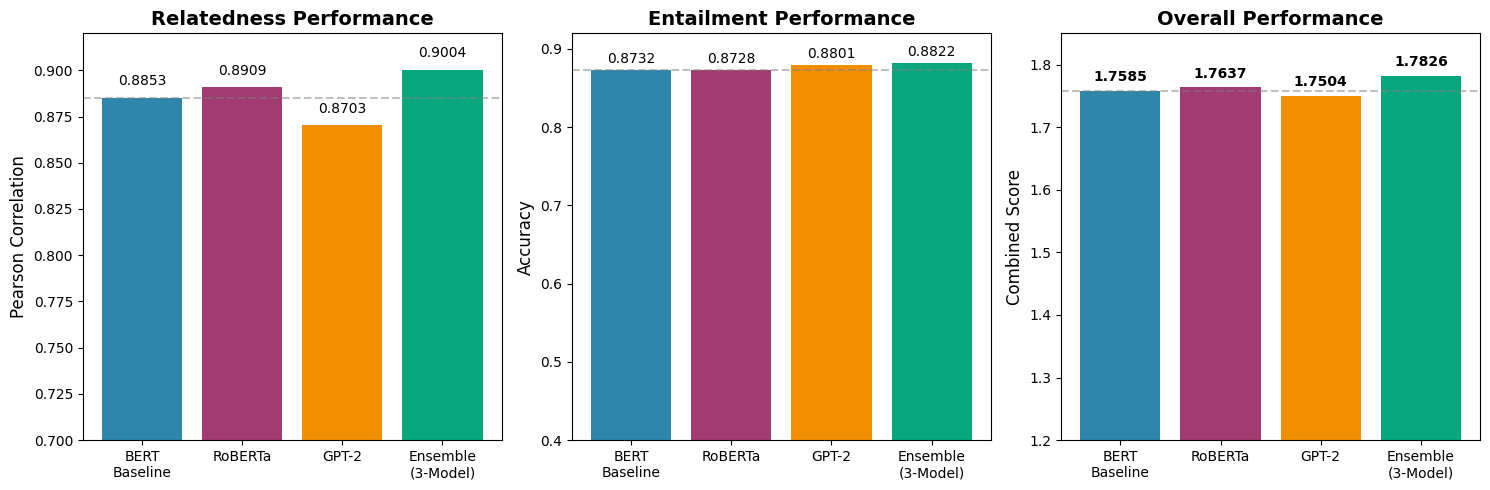


模型效能詳細比較
Model                     Pearson      Accuracy     Combined    
----------------------------------------------------------------------
BERT Baseline             0.8853       0.8732       1.7585      
RoBERTa                   0.8909       0.8728       1.7637      
GPT-2                     0.8703       0.8801       1.7504      
Three-Model Ensemble      0.9004       0.8822       1.7826      

相對於 BERT Baseline 的改進:
----------------------------------------------------------------------
BERT Baseline             +0.0000 (+0.00%)
RoBERTa                   +0.0052 (+0.29%)
GPT-2                     -0.0081 (-0.46%)
Three-Model Ensemble      +0.0241 (+1.37%)


In [78]:
import matplotlib.pyplot as plt
import numpy as np

# 準備數據
models = ['BERT\nBaseline', 'RoBERTa', 'GPT-2', 'Ensemble\n(3-Model)']
pearson_scores = [test_pearson_corr, roberta_test_pearson, gpt2_test_pearson, ensemble_test_pearson]
accuracy_scores = [test_accuracy, roberta_test_accuracy, gpt2_test_accuracy, ensemble_test_accuracy]
combined_scores = [p + a for p, a in zip(pearson_scores, accuracy_scores)]

# 創建圖表
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Pearson Correlation 比較
ax1 = axes[0]
bars1 = ax1.bar(models, pearson_scores, color=['#2E86AB', '#A23B72', '#F18F01', '#06A77D'])
ax1.set_ylabel('Pearson Correlation', fontsize=12)
ax1.set_title('Relatedness Performance', fontsize=14, fontweight='bold')
ax1.set_ylim(0.7, 0.92)
ax1.axhline(y=test_pearson_corr, color='gray', linestyle='--', alpha=0.5, label='BERT Baseline')
for i, (bar, score) in enumerate(zip(bars1, pearson_scores)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{score:.4f}', ha='center', va='bottom', fontsize=10)

# 2. Accuracy 比較
ax2 = axes[1]
bars2 = ax2.bar(models, accuracy_scores, color=['#2E86AB', '#A23B72', '#F18F01', '#06A77D'])
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Entailment Performance', fontsize=14, fontweight='bold')
ax2.set_ylim(0.4, 0.92)
ax2.axhline(y=test_accuracy, color='gray', linestyle='--', alpha=0.5, label='BERT Baseline')
for i, (bar, score) in enumerate(zip(bars2, accuracy_scores)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{score:.4f}', ha='center', va='bottom', fontsize=10)

# 3. Combined Score 比較
ax3 = axes[2]
bars3 = ax3.bar(models, combined_scores, color=['#2E86AB', '#A23B72', '#F18F01', '#06A77D'])
ax3.set_ylabel('Combined Score', fontsize=12)
ax3.set_title('Overall Performance', fontsize=14, fontweight='bold')
ax3.set_ylim(1.2, 1.85)
ax3.axhline(y=test_pearson_corr + test_accuracy, color='gray', linestyle='--', alpha=0.5, label='BERT Baseline')
for i, (bar, score) in enumerate(zip(bars3, combined_scores)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('./saved_models/ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 印出詳細比較
print("\n" + "=" * 70)
print("模型效能詳細比較")
print("=" * 70)
print(f"{'Model':<25} {'Pearson':<12} {'Accuracy':<12} {'Combined':<12}")
print("-" * 70)
for i, model in enumerate(['BERT Baseline', 'RoBERTa', 'GPT-2', 'Three-Model Ensemble']):
    print(f"{model:<25} {pearson_scores[i]:<12.4f} {accuracy_scores[i]:<12.4f} {combined_scores[i]:<12.4f}")
print("=" * 70)

# 計算各模型相對於 BERT baseline 的改進
print("\n相對於 BERT Baseline 的改進:")
print("-" * 70)
baseline_combined = test_pearson_corr + test_accuracy
for i, model in enumerate(['BERT Baseline', 'RoBERTa', 'GPT-2', 'Three-Model Ensemble']):
    improvement = combined_scores[i] - baseline_combined
    improvement_pct = (improvement / baseline_combined) * 100
    print(f"{model:<25} {improvement:+.4f} ({improvement_pct:+.2f}%)")
print("=" * 70)